# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D)
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it


## Train the classifier
### Load the dataset
The dataset is generated by the notebook file `mimic_dataset_prep.ipynb`.\
In `train_config.yaml` set the `training_method` to `GRUD`. 

In [2]:
import os
import yaml
import pickle

# Load the config.yaml file
with open("train_config.yaml", "r") as file:
    train_config = yaml.safe_load(file)

# Determine training method and paths
#TODO: DO we want GRUD traning mode in the config file or not?
assert train_config['train']['training_method'] == 'GRUD', "The training config is not set to GRUD"
use_LR = False
data_path = train_config['data']['data_dir']
path = os.path.join(data_path, "LR_data" if use_LR else "GRUD_data")

# File paths
dataset_path = os.path.join(path, "dataset.pkl")
indices_path = os.path.join(path, "indices.pkl")

# Load dataset and indices
if os.path.exists(dataset_path) and os.path.exists(indices_path):
    print("Loading dataset...")
    
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)

    with open(indices_path, "rb") as f:
        indices_dict = pickle.load(f)
        train_indices = indices_dict["train_indices"]
        test_indices = indices_dict["test_indices"]
        early_stop_indices = indices_dict["early_stop_indices"]
        #TODO: fix this
        data_indices = train_indices + test_indices + early_stop_indices

    print(f"Loaded dataset and indices from {path}")
else:
    raise FileNotFoundError("Dataset not found.\n→ Run 'mimic_dataset_prep.ipynb' to generate the required dataset.\n")


Loading dataset...


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loaded dataset and indices from ./data/GRUD_data


Create dala loaders. The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [3]:
from torch.utils.data import DataLoader
from mimic_data_handler import MIMICUserDataset


data = dataset.data
targets = dataset.targets

train_subset = MIMICUserDataset(data[train_indices], targets[train_indices])
test_subset = MIMICUserDataset(data[test_indices], targets[test_indices])
early_stop_subset = MIMICUserDataset(data[early_stop_indices], targets[early_stop_indices])

# Create DataLoaders
batch_size = 59
train_loader = DataLoader(train_subset, batch_size=batch_size)
test_loader = DataLoader(test_subset, batch_size=batch_size)
early_stop_loader = DataLoader(early_stop_subset, batch_size=batch_size)


The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [4]:
optimized_hyperparams ={
    "hidden_size": 78,
    "learning_rate": 0.00473,
    "num_epochs": 150,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 3,
    "batch_size": batch_size,
    "seed": 4410,
    "min_delta": 0.00001,
    }

In [5]:
from torch import  nn, optim, save, zeros
from mimic_model_handler import GRUHandler
from target_models import GRUD
import os
import pickle

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": int(data.shape[1]/3),
    "X_mean":  zeros(1,data.shape[2],int(data.shape[1]/3)),
    "output_last": False,
    "bn_flag": True,
}

# Initialize the model with filtered parameters
model = GRUD(**model_params)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=optimized_hyperparams["learning_rate"])

# Train the model
train_results = GRUHandler().train(train_loader,
                                    model,
                                    criterion,
                                    optimizer,
                                    optimized_hyperparams["num_epochs"],
                                    early_stop_loader,
                                    optimized_hyperparams["patience_early_stopping"],
                                    optimized_hyperparams["patience_lr_scheduler"],
                                    optimized_hyperparams["min_delta"],
                                    )

# Evaluate the model
test_results = GRUHandler().eval(test_loader, model, criterion)


# Store model and its metadata
model = train_results.model
model.to("cpu")
target_dir = "target_GRUD"
os.makedirs(target_dir, exist_ok=True)
with open(target_dir+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_results,
                                    optimizer = optimizer,
                                    loss_fn = criterion,
                                    dataloader = train_loader,
                                    test_result = test_results,
                                    epochs = optimized_hyperparams["num_epochs"],
                                    train_indices = train_indices,
                                    test_indices = test_indices,
                                    dataset_name = train_config["data"]["dataset"])

with open(target_dir + "/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0: train_loss=0.624068, train_acc=0.6689


Training Progress:   1%|          | 1/150 [00:07<18:14,  7.35s/it]

Epoch 0: Validation loss improved to 0.603043
Epoch 1: train_loss=0.597745, train_acc=0.6922


Training Progress:   1%|▏         | 2/150 [00:14<17:22,  7.05s/it]

Epoch 1: No improvement. Patience 1/40
Epoch 2: train_loss=0.579120, train_acc=0.7102


Training Progress:   2%|▏         | 3/150 [00:21<17:07,  6.99s/it]

Epoch 2: No improvement. Patience 2/40
Epoch 3: train_loss=0.551087, train_acc=0.7292


Training Progress:   3%|▎         | 4/150 [00:28<17:26,  7.17s/it]

Epoch 3: No improvement. Patience 3/40
Epoch 4: train_loss=0.523304, train_acc=0.7560


Training Progress:   3%|▎         | 5/150 [00:35<17:33,  7.26s/it]

Epoch 4: No improvement. Patience 4/40
Epoch 5: train_loss=0.487477, train_acc=0.7781


Training Progress:   4%|▍         | 6/150 [00:43<17:34,  7.33s/it]

Epoch 5: No improvement. Patience 5/40
Epoch 6: train_loss=0.409720, train_acc=0.8197


Training Progress:   5%|▍         | 7/150 [00:50<17:33,  7.37s/it]

Epoch 6: No improvement. Patience 6/40
Epoch 7: train_loss=0.343155, train_acc=0.8566


Training Progress:   5%|▌         | 8/150 [00:58<17:27,  7.38s/it]

Epoch 7: No improvement. Patience 7/40
Epoch 8: train_loss=0.288968, train_acc=0.8867


Training Progress:   6%|▌         | 9/150 [01:05<17:24,  7.41s/it]

Epoch 8: No improvement. Patience 8/40
Epoch 9: train_loss=0.253961, train_acc=0.9059


Training Progress:   7%|▋         | 10/150 [01:13<17:18,  7.42s/it]

Epoch 9: No improvement. Patience 9/40
Epoch 10: train_loss=0.207454, train_acc=0.9270


Training Progress:   7%|▋         | 11/150 [01:20<17:12,  7.43s/it]

Epoch 10: No improvement. Patience 10/40
Epoch 11: train_loss=0.192826, train_acc=0.9323


Training Progress:   8%|▊         | 12/150 [01:28<17:05,  7.43s/it]

Epoch 11: No improvement. Patience 11/40
Epoch 12: train_loss=0.180500, train_acc=0.9366


Training Progress:   9%|▊         | 13/150 [01:36<17:22,  7.61s/it]

Epoch 12: No improvement. Patience 12/40
Epoch 13: train_loss=0.175968, train_acc=0.9390


Training Progress:   9%|▉         | 14/150 [01:44<18:04,  7.98s/it]

Epoch 13: No improvement. Patience 13/40
Epoch 14: train_loss=0.161116, train_acc=0.9466


Training Progress:  10%|█         | 15/150 [01:53<18:30,  8.22s/it]

Epoch 14: No improvement. Patience 14/40
Epoch 15: train_loss=0.158408, train_acc=0.9472


Training Progress:  11%|█         | 16/150 [02:02<18:44,  8.39s/it]

Epoch 15: No improvement. Patience 15/40
Epoch 16: train_loss=0.160727, train_acc=0.9441


Training Progress:  11%|█▏        | 17/150 [02:11<18:50,  8.50s/it]

Epoch 16: No improvement. Patience 16/40
Epoch 17: train_loss=0.153924, train_acc=0.9462


Training Progress:  12%|█▏        | 18/150 [02:20<18:54,  8.59s/it]

Epoch 17: No improvement. Patience 17/40
Epoch 18: train_loss=0.155712, train_acc=0.9489


Training Progress:  13%|█▎        | 19/150 [02:28<18:53,  8.65s/it]

Epoch 18: No improvement. Patience 18/40
Epoch 19: train_loss=0.154504, train_acc=0.9482


Training Progress:  13%|█▎        | 20/150 [02:37<18:50,  8.69s/it]

Epoch 19: No improvement. Patience 19/40
Epoch 20: train_loss=0.156378, train_acc=0.9466


Training Progress:  14%|█▍        | 21/150 [02:46<18:45,  8.73s/it]

Epoch 20: No improvement. Patience 20/40
Epoch 21: train_loss=0.154742, train_acc=0.9479


Training Progress:  15%|█▍        | 22/150 [02:55<18:37,  8.73s/it]

Epoch 21: No improvement. Patience 21/40
Epoch 22: train_loss=0.152012, train_acc=0.9503


Training Progress:  15%|█▌        | 23/150 [03:04<18:31,  8.76s/it]

Epoch 22: No improvement. Patience 22/40
Epoch 23: train_loss=0.151150, train_acc=0.9485


Training Progress:  16%|█▌        | 24/150 [03:12<18:23,  8.76s/it]

Epoch 23: No improvement. Patience 23/40
Epoch 24: train_loss=0.150588, train_acc=0.9502


Training Progress:  17%|█▋        | 25/150 [03:21<18:16,  8.77s/it]

Epoch 24: No improvement. Patience 24/40
Epoch 25: train_loss=0.151460, train_acc=0.9489


Training Progress:  17%|█▋        | 26/150 [03:30<18:09,  8.78s/it]

Epoch 25: No improvement. Patience 25/40
Epoch 26: train_loss=0.151863, train_acc=0.9500


Training Progress:  18%|█▊        | 27/150 [03:39<18:01,  8.79s/it]

Epoch 26: No improvement. Patience 26/40
Epoch 27: train_loss=0.155134, train_acc=0.9486


Training Progress:  19%|█▊        | 28/150 [03:48<17:53,  8.80s/it]

Epoch 27: No improvement. Patience 27/40
Epoch 28: train_loss=0.151063, train_acc=0.9485


Training Progress:  19%|█▉        | 29/150 [03:56<17:44,  8.80s/it]

Epoch 28: No improvement. Patience 28/40
Epoch 29: train_loss=0.151334, train_acc=0.9498


Training Progress:  20%|██        | 30/150 [04:05<17:36,  8.80s/it]

Epoch 29: No improvement. Patience 29/40
Epoch 30: train_loss=0.146987, train_acc=0.9511


Training Progress:  21%|██        | 31/150 [04:14<17:28,  8.81s/it]

Epoch 30: No improvement. Patience 30/40
Epoch 31: train_loss=0.149895, train_acc=0.9497


Training Progress:  21%|██▏       | 32/150 [04:23<17:19,  8.81s/it]

Epoch 31: No improvement. Patience 31/40
Epoch 32: train_loss=0.153199, train_acc=0.9494


Training Progress:  22%|██▏       | 33/150 [04:31<17:00,  8.72s/it]

Epoch 32: No improvement. Patience 32/40
Epoch 33: train_loss=0.150446, train_acc=0.9512


Training Progress:  23%|██▎       | 34/150 [04:39<16:10,  8.36s/it]

Epoch 33: No improvement. Patience 33/40
Epoch 34: train_loss=0.154885, train_acc=0.9460


Training Progress:  23%|██▎       | 35/150 [04:46<15:34,  8.13s/it]

Epoch 34: No improvement. Patience 34/40
Epoch 35: train_loss=0.153502, train_acc=0.9490


Training Progress:  24%|██▍       | 36/150 [04:54<15:08,  7.97s/it]

Epoch 35: No improvement. Patience 35/40
Epoch 36: train_loss=0.155736, train_acc=0.9490


Training Progress:  25%|██▍       | 37/150 [05:02<14:47,  7.85s/it]

Epoch 36: No improvement. Patience 36/40
Epoch 37: train_loss=0.152735, train_acc=0.9474


Training Progress:  25%|██▌       | 38/150 [05:09<14:30,  7.77s/it]

Epoch 37: No improvement. Patience 37/40
Epoch 38: train_loss=0.152264, train_acc=0.9499


Training Progress:  26%|██▌       | 39/150 [05:17<14:16,  7.72s/it]

Epoch 38: No improvement. Patience 38/40
Epoch 39: train_loss=0.153229, train_acc=0.9496


Training Progress:  27%|██▋       | 40/150 [05:24<14:03,  7.67s/it]

Epoch 39: No improvement. Patience 39/40
Epoch 40: train_loss=0.151075, train_acc=0.9493


Training Progress:  27%|██▋       | 40/150 [05:32<15:14,  8.31s/it]

Epoch 40: No improvement. Patience 40/40
Early stopping at epoch 40. Best val loss: 0.603043


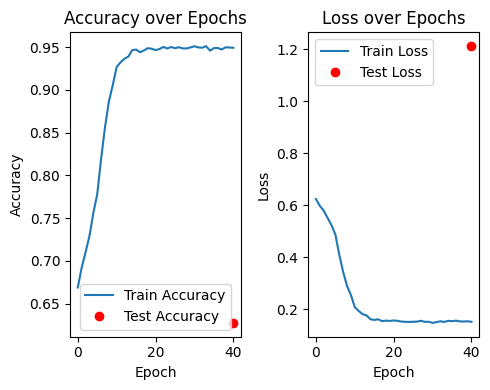

In [6]:
import matplotlib.pyplot as plt

train_acc = train_results.metrics.extra["accuracy_history"]
train_loss = train_results.metrics.extra["loss_history"]
test_acc = test_results.accuracy
test_loss = test_results.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

##  Attacking the GRUD model
Modify ```audit.yaml ``` file to attack GRUD model: 
  
  ```
  model_class: "GRUD"
  target_folder: "./target_GRUD"
  data_path: "./data/GRUD_data/dataset.pkl"
  ```

In [1]:
import os
import sys
from leakpro import LeakPro
from mimic_model_handler import GRUHandler

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it

# Read the config file
config_path = "audit.yaml"

# Instantiate leakpro object
leakpro = LeakPro(GRUHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(create_pdf=True)

/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-06-11 20:06:53,091 INFO     Target model blueprint created from GRUD in ./target_models.py.
06/11/2025 20:06:53:INFO:Target model blueprint created from GRUD in ./target_models.py.
2025-06-11 20:06:53,330 INFO     Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
06/11/2025 20:06:53:INFO:Loaded target model metadata from ./target_GRUD_dpsgd/model_metadata.pkl
/home/fazeleh/LeakPro/leakpro/input_handler/mia_hand

<Figure size 640x480 with 0 Axes>